### 1.前処理(ポケモンカードデータ)

#### 1.1 小売価格データの前処理の概要
##### ・ファイル：pokemon_cards_with_titles.csv
##### ・問題点：行31・48に2商品が1行で記載
##### ・対応策：各行を2行に分割して整理
##### ・出力：整形済みデータをpokemon_cards_split.csvに保存

##### ライブラリのインポートとファイルの読み込み

In [21]:
import pandas as pd

file_path = "pokemon_cards_with_titles.csv"
df = pd.read_csv(file_path)


##### 分割対象の行インデックス指定と構造確認

In [22]:

rows_to_split = [29, 46]
df.loc[rows_to_split, 'パック名']

29    拡張パック『時空の創造 ダイヤモンドコレクション』『時空の創造 パールコレクション』
46                 拡張パック『ブラックコレクション』『ホワイトコレクション』
Name: パック名, dtype: object

##### パック名の分割処理

In [23]:
# 分割後の行を格納するリスト
new_rows = []

# 全行を処理
for i, row in df.iterrows():
    if i in rows_to_split and row['パック名'].count('『') == 2 and row['パック名'].count('』') == 2:
        # 接頭辞（例：「拡張パック」など）を抽出
        prefix = row['パック名'].split('『')[0]

        # 2つの商品名に分割
        parts = row['パック名'].split('』『')
        part1 = prefix + parts[0].replace(prefix, '') + '』'
        part2 = prefix + '『' + parts[1]

        # 分割結果を2行として追加
        new_rows.append([part1, row['発売日'], row['希望小売価格'], row['カード枚数']])
        new_rows.append([part2, row['発売日'], row['希望小売価格'], row['カード枚数']])
    else:
        # その他の行はそのまま追加
        new_rows.append(row.tolist())

##### 新しいDataFrameの作成と保存

In [24]:
# 新しいDataFrameを作成
new_df = pd.DataFrame(new_rows, columns=df.columns)

# CSVファイルに保存
new_df.to_csv("pokemon_cards_split.csv", index=False)


#### 1.2 買取価格データの前処理の概要
##### ファイル：pack_only.csv

##### ステップ1：不要なパック名を除外 → filtered_pack_only.csvに保存

##### ステップ2：小売価格データと同じ表記に統一 → filtered_pack_only_cleansing.csvに保存



##### CSVファイルの読み込み

In [25]:
file_path = "pack_only.csv"
df = pd.read_csv(file_path)

##### 除外するキーワードリストの定義

In [26]:
exclude_keywords = [
    'ギフトパック', 'スターターパック', 'VSパック', '構築',
    'コレクションシート', 'デッキ', 'スペシャル', 'プレミアム',
    'サザンアイランド', '映画', 'タイプユニット'
]

pattern = '|'.join(exclude_keywords)

##### フィルタ処理の実行とCSVファイルへの保存

In [27]:
filtered_df = df[~df['カード名/商品名'].str.contains(pattern, na=False)]
output_path = "filtered_pack_only.csv"
filtered_df.to_csv(output_path, index=False, encoding='utf-8-sig')

#### 1.3 前処理した2つのCSVファイルを結合し，merged_data.csvとして保存

##### CSVファイルの読み込み

In [28]:
df1 = pd.read_csv("pokemon_cards_split.csv")
df2 = pd.read_csv("filtered_pack_only_cleansing.csv")

##### パック名で結合

In [29]:
merged_df = pd.merge(df1, df2, on="パック名", how="left")

##### 列の順番を並び変える

In [30]:
desired_order = ["パック名", "発売日", "希望小売価格", "買取価格", "カード枚数"]
merged_df = merged_df[desired_order]

##### CSVとして保存

In [31]:
output_filename = "merged_data_ver2.csv"
merged_df.to_csv(output_filename, index=False, encoding="utf-8-sig")

#### 1.4 買取価格の欠損補完（merged_data_ver2）

- 欠損の種類：

  - **BOXのみに価格あり**  
    → BOX価格 ÷ パック数で補完（※小数点切り捨て）

  - **カードラッシュに価格なし**  
    → 他サイトの買取価格で補完

- 補完後のデータを `merged_data_all.csv` として保存


### 2. 貴金属（金/銀/プラチナ）データについて

##### 貴金属価格データの保存(Investing.com)
##### ・金・銀：1996/10/20-2025/06/01→gold_data.csv, silver_data.csv
##### ・プラチナ：2009/10/14-2025/06/01→platinum_data.csv

### 3. 分析準備

##### ライブラリのインポートとファイル読み込み

In [32]:
from datetime import datetime

# ファイル読み込み
poke_df = pd.read_csv("merged_data_all.csv")
gold_df = pd.read_csv("gold_data.csv")
silver_df = pd.read_csv("silver_data.csv", encoding="utf-8-sig")

##### 日付と価格の整形

In [33]:
# ポケモンカードデータの整形
poke_df["発売日"] = pd.to_datetime(poke_df["発売日"], format="%Y年%m月%d日", errors="coerce")
poke_df["希望小売価格"] = poke_df["希望小売価格"].astype(str).str.replace("円", "").str.replace(",", "").astype(float)
poke_df["買取価格"] = poke_df["買取価格"].astype(str).str.replace("¥", "").str.replace(",", "").astype(float)

# 金・銀データの整形
gold_df["日付け"] = pd.to_datetime(gold_df["日付け"])
silver_df["日付け"] = pd.to_datetime(silver_df["日付け"])
gold_df["終値"] = gold_df["終値"].astype(str).str.replace(",", "").astype(float)
silver_df["終値"] = silver_df["終値"].astype(str).str.replace(",", "").astype(float)

##### 経過年数の計算

In [34]:
# 比較基準日（2025年6月1日）
latest_date = pd.to_datetime("2025-06-01")
poke_df["経過年数"] = (latest_date - poke_df["発売日"]).dt.days / 365.25

##### 発売日以降の価格を取得する関数

In [35]:
# 発売日当日以降の最も近い価格を取得する関数
def get_price_on_release(df, release_date):
    eligible = df[df["日付け"] >= release_date]
    return eligible.sort_values("日付け", ascending=True).iloc[0]["終値"] if not eligible.empty else None

##### 金・銀の発売日価格を取得

In [36]:
poke_df["金価格_発売日"] = poke_df["発売日"].apply(lambda x: get_price_on_release(gold_df, x))
poke_df["銀価格_発売日"] = poke_df["発売日"].apply(lambda x: get_price_on_release(silver_df, x))

##### ROI・CAGRの計算（ポケカ・金・銀）

In [37]:
# 価格（2025年6月1日時点）
gold_latest = gold_df[gold_df["日付け"] <= latest_date].sort_values("日付け", ascending=False).iloc[0]["終値"]
silver_latest = silver_df[silver_df["日付け"] <= latest_date].sort_values("日付け", ascending=False).iloc[0]["終値"]

# 金・銀のROI/CAGR計算
for metal, latest in [("金", gold_latest), ("銀", silver_latest)]:
    col = f"{metal}価格_発売日"
    poke_df[f"{metal}_ROI"] = (latest - poke_df[col]) / poke_df[col]
    poke_df[f"{metal}_CAGR"] = (latest / poke_df[col]) ** (1 / poke_df["経過年数"]) - 1

# ポケカのROI/CAGR計算
poke_df["ポケカ_ROI"] = (poke_df["買取価格"] - poke_df["希望小売価格"]) / poke_df["希望小売価格"]
poke_df["ポケカ_CAGR"] = (poke_df["買取価格"] / poke_df["希望小売価格"]) ** (1 / poke_df["経過年数"]) - 1

##### CSV出力

In [38]:
columns_to_export = [
    "パック名", "発売日", "希望小売価格", "買取価格", "カード枚数", "経過年数",
    "金価格_発売日", "金_ROI", "金_CAGR",
    "銀価格_発売日", "銀_ROI", "銀_CAGR",
    "ポケカ_ROI", "ポケカ_CAGR"
]

# CSVとして保存（文字化け防止のUTF-8 BOM付き）
poke_df[columns_to_export].to_csv("pokeka_vs_gold_silver_utf8bom.csv", index=False, encoding="utf-8-sig")

### 4. 分析(可視化)

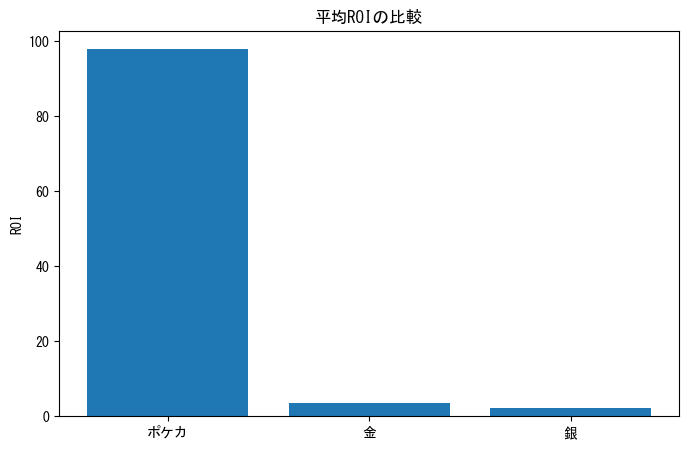

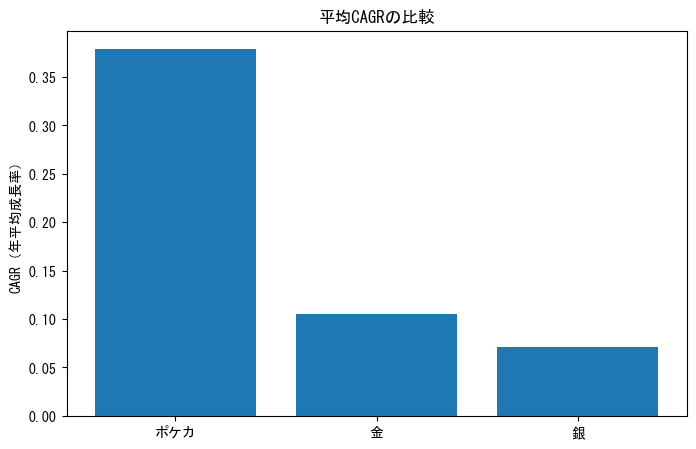

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 日本語フォントを設定
mpl.rcParams['font.family'] = 'MS Gothic'

# 平均ROIとCAGRの計算
roi_means = {
    "ポケカ": poke_df["ポケカ_ROI"].mean(),
    "金": poke_df["金_ROI"].mean(),
    "銀": poke_df["銀_ROI"].mean()
}

cagr_means = {
    "ポケカ": poke_df["ポケカ_CAGR"].mean(),
    "金": poke_df["金_CAGR"].mean(),
    "銀": poke_df["銀_CAGR"].mean()
}

# ROIの棒グラフ
plt.figure(figsize=(8, 5))
plt.bar(roi_means.keys(), roi_means.values())
plt.title("平均ROIの比較")
plt.ylabel("ROI")
plt.show()

# CAGRの棒グラフ
plt.figure(figsize=(8, 5))
plt.bar(cagr_means.keys(), cagr_means.values())
plt.title("平均CAGRの比較")
plt.ylabel("CAGR（年平均成長率）")
plt.show()

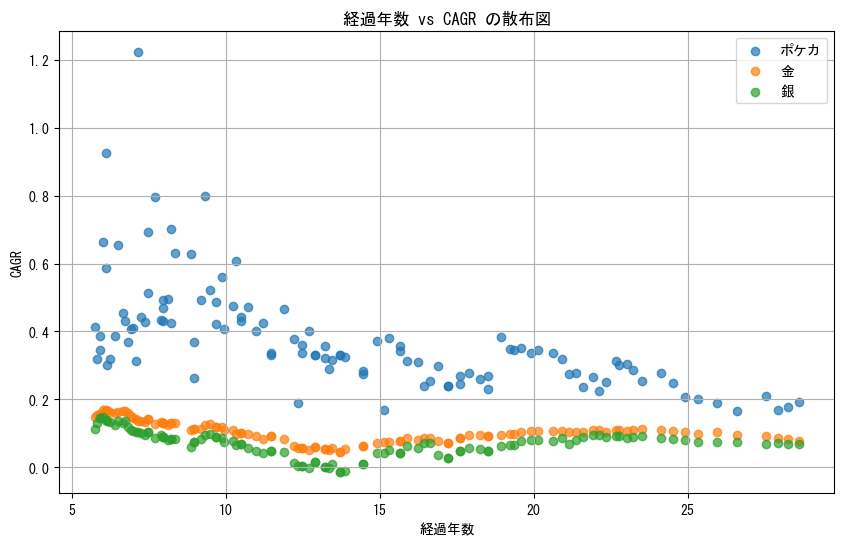

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(poke_df["経過年数"], poke_df["ポケカ_CAGR"], label="ポケカ", alpha=0.7)
plt.scatter(poke_df["経過年数"], poke_df["金_CAGR"], label="金", alpha=0.7)
plt.scatter(poke_df["経過年数"], poke_df["銀_CAGR"], label="銀", alpha=0.7)
plt.title("経過年数 vs CAGR の散布図")
plt.xlabel("経過年数")
plt.ylabel("CAGR")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\zakky\AppData\Local\Temp\ipykernel_22724\3936191916.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


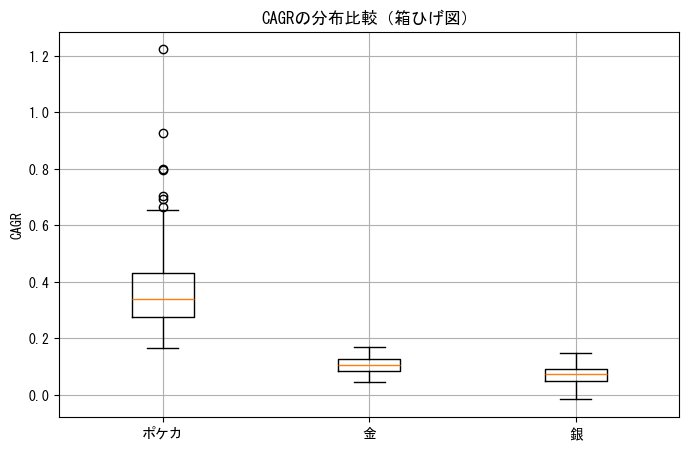

In [42]:
plt.figure(figsize=(8, 5))
plt.boxplot([
    poke_df["ポケカ_CAGR"].dropna(),
    poke_df["金_CAGR"].dropna(),
    poke_df["銀_CAGR"].dropna()
], labels=["ポケカ", "金", "銀"])
plt.title("CAGRの分布比較（箱ひげ図）")
plt.ylabel("CAGR")
plt.grid(True)
plt.show()